# Advanced learning

In [1]:
'''import sys
reload(sys)
sys.setdefaultencoding("utf-8")'''
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import time
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import itemfreq

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load the raw dataset

def load_data_set():
    train_data = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    test["outcome"] = 9
    bids = pd.read_csv('bids.csv')
    #bids = bids.sort(['auction', 'time'])
    return train_data,bids,test

train,bids,test = load_data_set()
def test_loading(train,test,bids):
    time_auction = pd.read_csv('res/time_auction.csv')
    auctions_stats = pd.read_csv('res/stats_test.csv')
    auctions_stats_simple = pd.read_csv("res/stats_test_simple.csv")
    auctions_stats = auctions_stats.groupby('bidder_id',as_index=False).mean()
    '''print(auctions_stats.bidder_id)
    print(auctions_stats_simple.bidder_id)
    auctions_stats.rename(columns=lambda x: x+str("_c"), inplace=True)
    auctions_stats.rename(columns={"bidder_id_c":"bidder_id"},inplace=True)'''
    auctions_stats = pd.merge(auctions_stats,time_auction,on="bidder_id")
    auctions_stats_simple = pd.merge(auctions_stats_simple,auctions_stats,on="bidder_id")
    new_train = train[["bidder_id","outcome"]].copy()
    #y_train = train["outcome"]
    new_test = test[["bidder_id"]].copy()
    new_train = pd.merge(new_train,auctions_stats_simple,on="bidder_id")
    y_train = new_train["outcome"]
    #new_train = new_train.drop("outcome",axis=1)
    new_test = pd.merge(new_test,auctions_stats_simple,on="bidder_id")
    #new_test= new_test.fillna(mean_s)
    #new_train= new_train.fillna(mean_s)
    return new_train,new_test,y_train

X_train,X_test,y_train = test_loading(train,test,bids)
print(X_test.bidder_id.unique().shape)
print(X_train.bidder_id.unique().shape)
#X_trXain,X_test,y_train = load_all(train,test,bids)

(4630,)
(1984,)


In [3]:
train = pd.read_csv("debug_train.csv")
train['outcome'] = train['outcome'].astype(int)
ytrain = train['outcome']
train.drop('outcome', 1, inplace=True)
train.drop(labels=['bidder_id'], axis=1, inplace=True)
test = pd.read_csv("debug_test.csv")

In [4]:
import os.path
if os.path.exists('stacking_5.pickle'):
    models_fitted = joblib.load('stacking_5.pickle')
else:
    models_fitted = []


NameError: name 'joblib' is not defined

In [31]:
# weights
#m1,m2,m3,m4,m5
weights = [0.9200,0.9212,0.9229,0.92469,0.9215]


# first ml algo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,Lasso,SGDRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


def predict(X_train, X_test, y_train,clf=RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy'),mode='soft'):
    clf.fit(X_train, y_train)
    if mode=="soft":
        predictions = clf.predict_proba(X_test)[:, 1]
    elif mode=="hard":
        print("Predict Class")
        predictions = clf.predict(X_test)
    return predictions

def predict_model(X_train, X_test, y_train,model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

def cross_val_score(train,ytrain,model):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    scores = []
    for train_index, test_index in kf:
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        predictions = predict(X_train, X_test, y_train,clf=model)
        scores.append(roc_auc_score(y_test, predictions))
    print np.mean(scores)

def test_models(train,ytrain):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    models = [RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'),AdaBoostClassifier(),
             GradientBoostingClassifier(),KNeighborsClassifier(),AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')),
             SVC(kernel="poly",probability=True),SVC(probability=True),DecisionTreeClassifier()]
    res_per_models = {}
    for m in models:
        print("-------------------------")
        print(str(m))
        start = time.time()
        scores = []
        for train_index, test_index in kf:
            X_train, X_test = train.iloc[train_index], train.iloc[test_index]
            y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
            predictions = predict_model(X_train, X_test, y_train,m)
            scores.append(roc_auc_score(y_test, predictions))
        print np.mean(scores)
        end = time.time()
        res_per_models[str(m)] = (np.mean(scores),end)
    with open('multi_modles.pickle', 'wb') as handle:
        pickle.dump(res_per_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

def mean_predict(X_train, X_test, y_train,models):
    total_predict = []
    for name,model in models:
        total_predict.append(predict(X_train, X_test, y_train,clf=model,mode='soft'))
    predictions = np.mean(total_predict,axis=0)
    return predictions
def mean_predict_weights(X_train, X_test, y_train,models,w):
    total_predict = []
    i = 0
    for name,model in models:
        total_predict.append(predict(X_train, X_test, y_train,clf=model,mode='soft'))
        i+=1
    predictions = np.average(total_predict,axis=0,weights=w)
    #print("befor ", predictions)
    #predictions = predictions/float(np.sum(w))
    #print("after ", predictions)
    return predictions
def special_hard(predictions):
    predictions_rounded = []
    for tab in predictions:
        predictions_rounded.append([(int((round(tab[i],2)*20))/20.0) for i in range(len(tab))])
    predictions_rounded = np.array(predictions_rounded)
    freq_test = []
    for i in range(len(predictions_rounded[0])):
        freq_test.append(itemfreq(predictions_rounded[:,i]))
    final_pred = []
    for i in range(len(freq_test)):
        if len(freq_test[i])==5:
            final_pred.append(np.mean(freq_test[i][:,0]))
        else:
            final_pred.append(freq_test[i][np.argmax(freq_test[i][:,1])][0])
    return final_pred

def special_hard_weights(predictions,w):
    predictions_rounded = []
    for tab in predictions:
        predictions_rounded.append([(int((round(tab[i],2)*20))/20.0) for i in range(len(tab))])
    predictions_rounded = np.array(predictions_rounded)
    freq_test = []
    new_predictions_rounded = []
    new_w = [int(we*1000) for we in w]
    for i in range(len(predictions_rounded)):
        for k in range(new_w[i]):
            new_predictions_rounded.append(predictions_rounded[:,i])
    new_predictions_rounded = np.array(new_predictions_rounded)
    print(new_predictions_rounded.shape)
    for i in range(len(predictions_rounded[0])):
        freq_test.append(itemfreq(predictions_rounded[:,i]))
    final_pred = []
    for i in range(len(freq_test)):
        if len(freq_test[i])==5:
            final_pred.append(np.mean(freq_test[i][:,0]))
        else:
            final_pred.append(freq_test[i][np.argmax(freq_test[i][:,1])][0])
    return final_pred
def voting_classifier_model_weights(train,ytrain,weights,hard= 'soft'):
    m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
    m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
    m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
    m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
    m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
    models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
    if hard != 'mean':
        eclf1 = VotingClassifier(estimators=models,voting=hard,weights=weights,n_jobs=-1)
    kf = StratifiedKFold(y=ytrain, n_folds=10,random_state=9)
    scores = []
    n_folds = 0
    for train_index, test_index in kf:
        print("Fold number : " , n_folds)
        n_folds +=1
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        if hard == "soft":
            predictions = predict(X_train, X_test, y_train,clf=eclf1,mode=hard)
        elif hard=="hard":
            total_pred = []
            for name,mo in models:
                total_pred.append(predict(X_train, X_test, y_train,clf=mo))
            predictions = special_hard_weights(total_pred,weights)
        else:
            predictions = mean_predict_weights(X_train, X_test, y_train,models,weights)
            '''total_predict = []
            for name,model in models:
                total_predict.append(predict(X_train, X_test, y_train,clf=model,mode='soft'))
            predictions = np.mean(total_predict,axis=0)'''
        scores.append(roc_auc_score(y_test, predictions))
    print np.mean(scores)
    
def stacking(train,ytrain,model):
    m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
    m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
    m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
    m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
    m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
    models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
    kf = StratifiedKFold(y=ytrain, n_folds=10,random_state=9)
    scores = []
    count_fold = 0
    for train_index, test_index in kf:
        print("Fold numero : " , count_fold)
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_train,y_train, test_size=0.33, random_state=42)
        predictions = np.zeros((len(X_test_meta),5))
        predictions_test = np.zeros((len(X_test),5))
        i= 0
        for m_name,model in models:
            model.fit(X_train_meta,y_train_meta)
            predictions[:,i] = model.predict_proba(X_test_meta)[:, 1]
            predictions_test[:,i] = model.predict_proba(X_test)[:, 1]
            i+=1
        #train the meta classifier
        meta_class  = model
        predictions = np.array(predictions)
        predictions_test = np.array(predictions_test)
        meta_class.fit(predictions,y_test_meta.values)
        predictions_test = meta_class.predict_proba(predictions_test)[:, 1]
        #prediction
        scores.append(roc_auc_score(y_test, predictions_test))
        count_fold += 1 
    print("STACKING score " , np.mean(scores))
    
def stacking_test(train,ytrain,model_meta,full_pred):
    m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
    m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
    m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
    m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
    m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
    models = [('rfc' , m1) ,('adCL' , m2) , ("gdC" , m3), ("adaRFC" , m4) , ("rfc2",m5)]
    nb_folds = 20
    kf = StratifiedKFold(y=ytrain, n_folds=nb_folds,random_state=99)
    scores = []
    count_fold = 0
    must_write = (len(full_pred)!=nb_folds)
    for train_index, test_index in kf:
        print("Fold numero : " , count_fold)
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        predictions = np.zeros((len(X_train),5))
        predictions_test = np.zeros((len(X_test),5))
        i= 0
        if len(full_pred)!=nb_folds:
            for m_name,model in models:
                model.fit(X_train,y_train)
                predictions[:,i] = model.predict_proba(X_train)[:, 1]
                predictions_test[:,i] = model.predict_proba(X_test)[:, 1]
                i+=1
            full_pred.append((predictions,predictions_test))
        else:
            predictions = full_pred[i][0]
            predictions_test = full_pred[i][1]
        #train the meta classifier
        predictions = np.array(predictions)
        predictions_test = np.array(predictions_test)
        #print(predictions,y_train)
        print(len(predictions),len(y_train.values))
        model_meta.fit(predictions,y_train.values)
        predictions_test = model_meta.predict_proba(predictions_test)[:, 1]
        #prediction
        scores.append(roc_auc_score(y_test, predictions_test))
        count_fold += 1 
    print("STACKING score " , np.mean(scores))
    if must_write:
        with open('stacking_5.pickle', 'wb') as handle:
            pickle.dump(full_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    
    
    
'''models = [RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy'),
   RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy'),
AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9),
GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9),
AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))]
for m in models:
    cross_val_score(train,ytrain,m)'''
#avec weights : 
'''voting_classifier_model_weights(train,ytrain,weights,hard="soft")
#sans weights : 
voting_classifier_model_weights(train,ytrain,[1,1,1,1,1],hard="soft")
#avec wieghts
voting_classifier_model_weights(train,ytrain,weights,hard="hard")
#sans weight
voting_classifier_model_weights(train,ytrain,[1,1,1,1,1],hard="hard")
#avec
voting_classifier_model_weights(train,ytrain,weights,hard="mean")
#sans 
voting_classifier_model_weights(train,ytrain,[1,1,1,1,1],hard="mean")'''
'''
print("hard  : ")
voting_classifier_model(train,ytrain,hard="hard")
print("mean  : ")
voting_classifier_model(train,ytrain,hard="mean")'''
#voting_classifier_model(train,ytrain,hard="hard")

'''
Resultats : avec soft : 0.932649417171
            sans foft : 0.929542942512
            avec hard : 0.90848198295
            sans hard: 0.903296708217
            avec mean : 0.934489842703
            sans mean : 0.933024802227

'''
#stacking_test(train,y_train,LogisticRegression(),models_fitted)
metas_classifieurs = [LogisticRegression(),LogisticRegression(penalty='l1'),LogisticRegression(penalty='l2'),
                     AdaBoostRegressor(),BaggingRegressor(),BaggingRegressor(n_estimators=100),GradientBoostingRegressor(),
                     RandomForestRegressor(),RandomForestRegressor(n_estimators=100),Lasso(),Lasso(normalize=True),SGDRegressor()]
for m in metas_classifieurs:
    stacking_test(train,y_train,m,models_fitted)
for m in metas_classifieurs:
    stacking(train,y_train,m,models_fitted)

('Fold numero : ', 0)
(1883, 1883)
('Fold numero : ', 1)
(1883, 1884)


ValueError: Found input variables with inconsistent numbers of samples: [1883, 1884]

to do : 
    
    - stacking vizualisation
    - stacking class challenge
    - bagging
    - graphe stacking 
    - autres graphes
    - graphe performances
    - test quelques paramètres
    - grid search paramètres meta-classfieur

In [74]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))


lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[m1,m2,m3,m4,m5],meta_classifier=lr, use_probas=True,average_probas=False)
skf = StratifiedKFold(y=ytrain, n_folds=10, random_state=99)
for clf, label in zip([m1,m2,m3,m4,m5,sclf], 
                      ['Rand F 250', 
                       'Ada 200', 
                       'Gradient 50',
                       'Ada RF',
                       'Random 300',
                       'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, train,y_train, 
                                              cv=skf,scoring='roc_auc')
    print("AUC: %0.6f (+/- %0.6f) [%s]" 
          % (scores.mean(), scores.std(), label))

AUC: 0.920043 (+/- 0.036885) [Rand F 250]
AUC: 0.922975 (+/- 0.025670) [Ada 200]
AUC: 0.924697 (+/- 0.027860) [Gradient 50]
AUC: 0.921396 (+/- 0.031403) [Ada RF]
AUC: 0.921292 (+/- 0.037076) [Random 300]
AUC: 0.931492 (+/- 0.027070) [StackingClassifier]


Random forest (250 estimators)
Adaboost (200 estimators)
Gradient boosting
Adaboost (random forest estimator)
Random forest (300 estimators)
Stacking Classifier


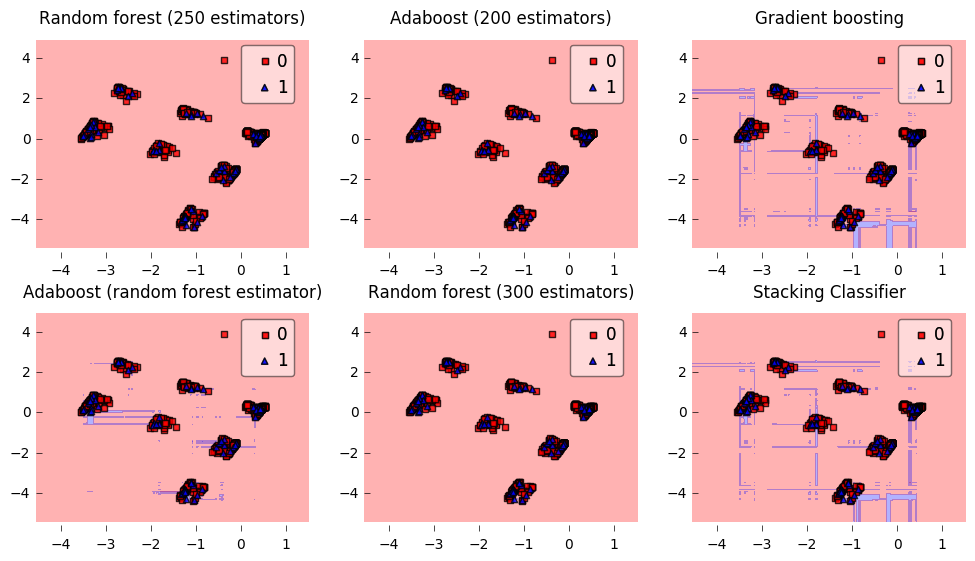

In [71]:
#vizualisation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


m1 = RandomForestClassifier(n_estimators=250,max_depth=8, random_state=9,criterion='entropy')
m5 = RandomForestClassifier(n_estimators=300,max_depth=8,  random_state=81,criterion='entropy')
m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
m3 = GradientBoostingClassifier(random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8,  random_state=9,criterion='entropy'))
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[m1,m2,m3,m4,m5],meta_classifier=lr, use_probas=True,average_probas=False)

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12,10))
X_pca = KernelPCA(n_components=2).fit_transform(train)
X_pca = StandardScaler().fit_transform(X_pca)
for clf, lab, grd in zip([m1,m2,m3,m4,m5,sclf], 
                         ['Random forest (250 estimators)', 
                       'Adaboost (200 estimators)', 
                       'Gradient boosting',
                       'Adaboost (random forest estimator)',
                       'Random forest (300 estimators)',
                       'Stacking Classifier'],
                          itertools.product([0, 1,2], repeat=2)):
    print(lab)
    clf.fit(X_pca,y_train.values.astype(np.integer))
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_pca, y=y_train.values.astype(np.integer), clf=clf)
    plt.title(lab)
plt.show()

In [7]:
#differents meta classifieurs : 
#use proba : True False
# average proba : True False
#differents ensembles de modelees
#grid search parametre meta classifieur

def stacking_models(classifieurs, meta_classifieur, proba, mean_proba,cv=15,retrain_all=False):
    sclf = StackingClassifier(classifiers=classifieurs,meta_classifier=meta_classifieur, use_probas=proba,average_probas=mean_proba)
    if retrain_all:
        for clf, label in zip([m1,m2,m3,m4,m5,sclf], 
                          ['Rand F 250', 
                           'Ada 200', 
                           'Gradient 50',
                           'Ada RF',
                           'Random 300',
                           'StackingClassifier']):
            scores = model_selection.cross_val_score(clf, train,y_train, 
                                                  cv=cv,scoring='roc_auc', n_jobs=-1)
            print("AUC: %0.6f (+/- %0.6f) [%s]" 
                  % (scores.mean(), scores.std(), label))
    else:
        print("RETRAIN FALSE")
        label = str(type(meta_classifieur))
        skf = StratifiedKFold(y=ytrain, n_folds=cv, random_state=99)
        scores = model_selection.cross_val_score(sclf, train,y_train, 
                                                  cv=skf,scoring='roc_auc',n_jobs=-1)
        print("AUC: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), label))

m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[m1,m2,m3,m4,m5],meta_classifier=lr, use_probas=True,average_probas=False)
        
lr = LogisticRegression(fit_intercept=False)
'''print("SANS PROBA " )
stacking_models([m1,m2,m3,m4,m5],lr,True,False,cv=10)
        
lr = LogisticRegression(class_weight={0:0.95,1:0.05})
print("SANS PROBA " )
stacking_models([m1,m2,m3,m4,m5],lr,True,False,cv=10)

lr = LogisticRegression(C= 0.01)
print("SANS PROBA " )
stacking_models([m1,m2,m3,m4,m5],lr,True,False,cv=10)

lr = LogisticRegression(C= 0.5)
print("SANS PROBA " )
stacking_models([m1,m2,m3,m4,m5],lr,True,False,cv=10)'''
'''print("MEAN PROBA " )
stacking_models([m1,m2,m3,m4,m5],lr,True,True,cv=10)'''


'''#several meta classifieurs:
metas_classifieurs = [LogisticRegression(),LogisticRegression(penalty='l1'),LogisticRegression(penalty='l2'),
                     AdaBoostClassifier(),BaggingClassifier(),BaggingClassifier(n_estimators=100),GradientBoostingClassifier(),
                     RandomForestClassifier(),RandomForestClassifier(n_estimators=100),SVC(kernel='linear',probability=True),
                      SVC(kernel="poly",probability=True),SVC(kernel="rbf",probability=True)]

for mo in metas_classifieurs:
    print(type(mo))
    stacking_models([m1,m2,m3,m4,m5],mo,True,False,cv=10)'''
    
'''
SANS PROBA : 
AUC: 0.641233 (+/- 0.105618) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
AVCE MOYENNE PROBAS:
AUC: 0.933136 (+/- 0.026770) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
NORMAL  :
 log regress (normal ): AUC: 0.931390 (+/- 0.027440)
 log regress (l1): AUC: 0.924697 (+/- 0.027860)
 log regress (l2): AUC: 0.931390 (+/- 0.027440)
 adaboost(1) : AUC: 0.861531 (+/- 0.083124)
 bagging : AUC: 0.739034 (+/- 0.086803)
 bagigng : AUC: 0.762195 (+/- 0.070357)
 gradient boosting : AUC: 0.725304 (+/- 0.087635)
 random forest : AUC: 0.752456 (+/- 0.089777)
 random forest : AUC: 0.769473 (+/- 0.069987)
 svm normal : AUC: 0.926550 (+/- 0.025666)
 svm poly : AUC: 0.930046 (+/- 0.028299)
 svm rbf : AUC: 0.899304 (+/- 0.045656)
 
 
 FIT INTERCEPT FALSE: AUC: AUC: 0.932230 (+/- 0.026649)
 weights : AUC: 0.931652 (+/- 0.027684)
 C = 0.01 AUC: 0.931870 (+/- 0.027917)
 C = 0.1 AUC: 0.931477 (+/- 0.027357)
'''

NameError: name 'LogisticRegression' is not defined

In [87]:
lr = LogisticRegression(n_jobs=-1)
sclf = StackingClassifier(classifiers=[m1,m2,m3,m4,m5],meta_classifier=lr, use_probas=True,average_probas=False)
params = {'meta-logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
          'meta-logisticregression__C': np.logspace(-3,3,10)}
skf = StratifiedKFold(y=ytrain, n_folds=5, random_state=99)
grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=skf,
                    n_jobs=-1,
                    scoring = "roc_auc",
                    refit=True)
grid.fit(train,y_train)
cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.6f +/- %0.6f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('AUC: %.6f' % grid.best_score_)
import pickle
with open('res_stacking.pickle', 'wb') as handle:
        pickle.dump(grid.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python2.7/dis

0.929644 +/- 0.011880 {'meta-logisticregression__C': 0.001, 'meta-logisticregression__solver': 'newton-cg'}
0.930106 +/- 0.011743 {'meta-logisticregression__C': 0.001, 'meta-logisticregression__solver': 'lbfgs'}
0.930236 +/- 0.011774 {'meta-logisticregression__C': 0.001, 'meta-logisticregression__solver': 'liblinear'}
0.929800 +/- 0.011875 {'meta-logisticregression__C': 0.001, 'meta-logisticregression__solver': 'sag'}
0.929556 +/- 0.011953 {'meta-logisticregression__C': 0.0046415888336127772, 'meta-logisticregression__solver': 'newton-cg'}
0.930184 +/- 0.011797 {'meta-logisticregression__C': 0.0046415888336127772, 'meta-logisticregression__solver': 'lbfgs'}
0.929144 +/- 0.012265 {'meta-logisticregression__C': 0.0046415888336127772, 'meta-logisticregression__solver': 'liblinear'}
0.929957 +/- 0.011724 {'meta-logisticregression__C': 0.0046415888336127772, 'meta-logisticregression__solver': 'sag'}
0.929653 +/- 0.012080 {'meta-logisticregression__C': 0.021544346900318832, 'meta-logisticreg

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
import xgboost as xgb
#vizualisation
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
#sacking : 
#3 models
m1 = RandomForestClassifier(n_estimators=250,max_depth=8, max_features = 45 , random_state=9,criterion='entropy')
m5 = RandomForestClassifier(n_estimators=300,max_depth=8, max_features = 30 , random_state=81,criterion='entropy')
m2 = AdaBoostClassifier(n_estimators=200,learning_rate=0.03,random_state=9)
m3 = GradientBoostingClassifier(max_features=50,random_state=9,n_estimators=200,learning_rate=0.1,max_depth=9)
m4 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'))
model_tmp=  RandomForestClassifier(n_estimators=160, max_features=42, max_depth=9, random_state=99,criterion='entropy')
m5 = BaggingClassifier(base_estimator=model_tmp, max_features=0.75,n_jobs=-1, n_estimators=60)
m6 = GradientBoostingClassifier(n_estimators=250,random_state=999,max_depth=6,learning_rate=0.025,max_features=37)
m7 = RandomForestClassifier(n_estimators=750, max_depth=None, random_state=99,min_samples_leaf=1, criterion='entropy')

models_test = [[m1,m2,m3],[m1,m2],[m1,m2,m3,m4],[m1,m2,m3,m4,m5],[m1,m2,m3,m4,m5,m6],[m1,m2,m3,m4,m5,m6,m7]]
count = 0
for mo in models_test:
    print("Model numero ", count)
    stacking_models(mo,LogisticRegression(),True,False,cv=10)
    count +=1

('Model numero ', 0)
RETRAIN FALSE
AUC: 0.928053 (+/- 0.029552) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
('Model numero ', 1)
RETRAIN FALSE
AUC: 0.927526 (+/- 0.030550) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
('Model numero ', 2)
RETRAIN FALSE
AUC: 0.931931 (+/- 0.026950) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
('Model numero ', 3)
RETRAIN FALSE


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


AUC: 0.930902 (+/- 0.027752) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
('Model numero ', 4)
RETRAIN FALSE


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


AUC: 0.929181 (+/- 0.027814) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]
('Model numero ', 5)
RETRAIN FALSE


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


AUC: 0.928910 (+/- 0.028870) [<class 'sklearn.linear_model.logistic.LogisticRegression'>]


In [16]:
from sklearn.ensemble import BaggingRegressor
#bagging : 
def bagging_score(model,nb_estimators=10,max_features=1.0):
    clf = BaggingRegressor(base_estimator=model,n_estimators=nb_estimators,n_jobs=-1,max_features=max_features)
    skf = StratifiedKFold(y=ytrain, n_folds=5, random_state=99)
    scores = model_selection.cross_val_score(clf, train,y_train, 
                                                  cv=skf,scoring='roc_auc',n_jobs=-1)
    print("AUC: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), str(type(model))))
    return scores.mean()
#simple bagging
models_bagging = [m1,m2,m3,m4,m5,m6,m7]
scores = []
for m in models_bagging:
    tmp = []
    for i in [10,20,50,100]:
        tmp.append((bagging_score(m,nb_estimators=i),bagging_score(m,nb_estimators=i,max_features = 0.80)))
    scores.append(tmp)

print("SCORESv : ", scores)
with open('bagging_simple.pickle', 'wb') as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


NameError: global name 'label' is not defined

#stacking : 

http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/

http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

https://github.com/rasbt/mlxtend

https://github.com/rasbt/mlxtend/blob/master/mlxtend/regressor/stacking_regression.py